<a href="https://colab.research.google.com/github/werowe/HypatiaAcademy/blob/master/English_to_Spanish_Translation_RNN_then_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15.2.1 English to Spanish Translation

[Chollet](https://livebook.manning.com/book/deep-learning-with-python-third-edition/chapter-15/v-4/70)


## sequence-to-sequence modeling

* Translation
* Question answering


1. An encoder model turns the source sequence into an intermediate representation.

2. A decoder is trained. It will recursively predict the next token in the target sequence by looking at all previous target tokens and our encoder’s representation of the source sequence.


During inference, we don’t have access to the target sequence – we’re trying to predict it from scratch. We will generate it one token at a time:

1. We obtain the encoded source sequence from the encoder.

- `how is the weather today`

2. The decoder starts by looking at the encoded source sequence as well as an initial “seed” token (such as the string "[start]"), and uses them to predict the first real token in the sequence.

3. The predicted sequence so far is fed back into the decoder, in a loop, until it generates a stop token (such as the string "[end]").

- `que`




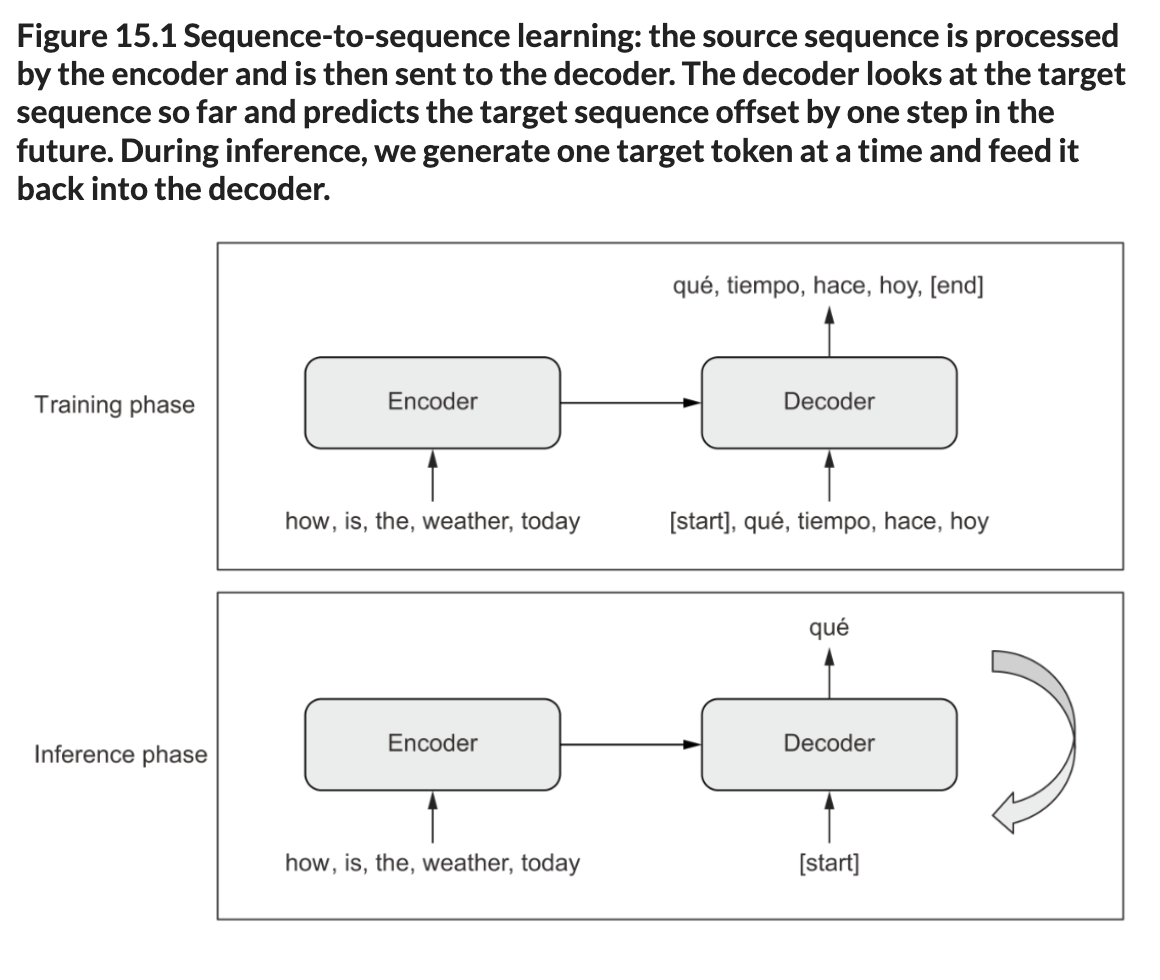

In [12]:
import pathlib
import keras

zip_path = keras.utils.get_file(
    origin=(
        "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    ),
    fname="spa-eng",
    extract=True,
)
text_path = pathlib.Path(zip_path) / "spa-eng" / "spa.txt"

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
with open(text_path) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [14]:
text_pairs[0]

('Go.', '[start] Ve. [end]')

In [15]:
import random

random.shuffle(text_pairs)
val_samples = int(0.15 * len(text_pairs))
train_samples = len(text_pairs) - 2 * val_samples
train_pairs = text_pairs[:train_samples]
val_pairs = text_pairs[train_samples : train_samples + val_samples]
test_pairs = text_pairs[train_samples + val_samples :]

Next, let’s prepare two separate **TextVectorization** layers: one for English and one for Spanish. We’re going to need to customize the way strings are preprocessed:

We need to preserve the "[start]" and "[end]" tokens that we’ve inserted. By default, the characters [ and ] would be stripped, but we want to keep them around so we can distinguish the word "start" from the start token "[start]".


In [16]:
import string
import re
from keras import layers
import tensorflow as tf

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", ""
    )

vocab_size = 15000
sequence_length = 20

english_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# here we can to use the function custom_standardization for the Spanish TextVectorization layer
spanish_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
english_tokenizer.adapt(train_english_texts)
spanish_tokenizer.adapt(train_spanish_texts)

Let's print part of the output to try to understand it.


1. custom_standardization(t) returns a TensorFlow string tensor (often an EagerTensor) after applying your custom standardization function.

2. .numpy() converts this TensorFlow tensor to a NumPy array (or, for a scalar string tensor, a bytes object) in eager execution mode.

3. .decode() is a standard Python method for converting bytes to a string (e.g., UTF-8 decoding).

In [17]:
spanish=train_spanish_texts[0]
print(spanish)

getText=custom_standardization(spanish).numpy().decode()

print("\nafter standardization", getText)

print("\ntokenize the spanish")
spanish_tokenizer(spanish).numpy()

[start] Esa isla tiene un clima tropical. [end]

after standardization [start] esa isla tiene un clima tropical [end]

tokenize the spanish


array([   2,  118, 1287,   39,   13,  848, 7503,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [18]:
# Show vocabulary stats
print(f"English vocabulary size: {len(english_tokenizer.get_vocabulary())}")
print(f"Spanish vocabulary size: {len(spanish_tokenizer.get_vocabulary())}")


English vocabulary size: 12066
Spanish vocabulary size: 15000


We can turn our data into a tf.data pipeline. We want it to return a tuple (inputs, target, sample_weights) where inputs is a dict with two keys:

1. "english" (the tokenized English sentence) and "spanish" (the tokenized Spanish sentence),

2. **target** is the Spanish sentence offset by one step ahead.

**sample_weights** here will be used to tell Keras which labels to use when calculating our loss and metrics.

In [19]:
batch_size = 64

def format_dataset(eng, spa):
    eng = english_tokenizer(eng)
    spa = spanish_tokenizer(spa)
    features = {"english": eng, "spanish": spa[:, :-1]}
    labels = spa[:, 1:]
    sample_weights = labels != 0
    return features, labels, sample_weights

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Print and look at some of this:

In [20]:
# Get the first batch from train_ds
first_train_batch = next(iter(train_ds))
# Get the first batch from val_ds
first_val_batch = next(iter(val_ds))


In [21]:
 inputs, targets, sample_weights = next(iter(train_ds))

 print("inputs keys", inputs.keys())

 print("english shape", inputs["english"].shape)

 print("spanish shape", inputs["spanish"].shape)

 print("targets shape", targets.shape)

 print("sample weights shape", sample_weights.shape)


print("\nFirst English sequence:", inputs["english"][0].numpy())


print("\nFirst Spanish sequence:", inputs["spanish"][0].numpy())


inputs keys dict_keys(['english', 'spanish'])
english shape (64, 20)
spanish shape (64, 20)
targets shape (64, 20)
sample weights shape (64, 20)

First English sequence: [   6   71   18  841    4 1097  267  274 1303    9   54  206  252    9
   54    4   15    0    0    0]

First Spanish sequence: [   2    6    8   26  487 2797 2103    6    9  247    4  121 2246  135
 1158  181    5   52    3    0]


##15.2.2 Sequence-to-sequence learning with RNNs
 In a proper sequence-to-sequence setup, you would first use an encoder RNN to turn the entire source sequence into a single representation of the source text. This could be the last output of the RNN or, alternatively, its final internal state vectors.

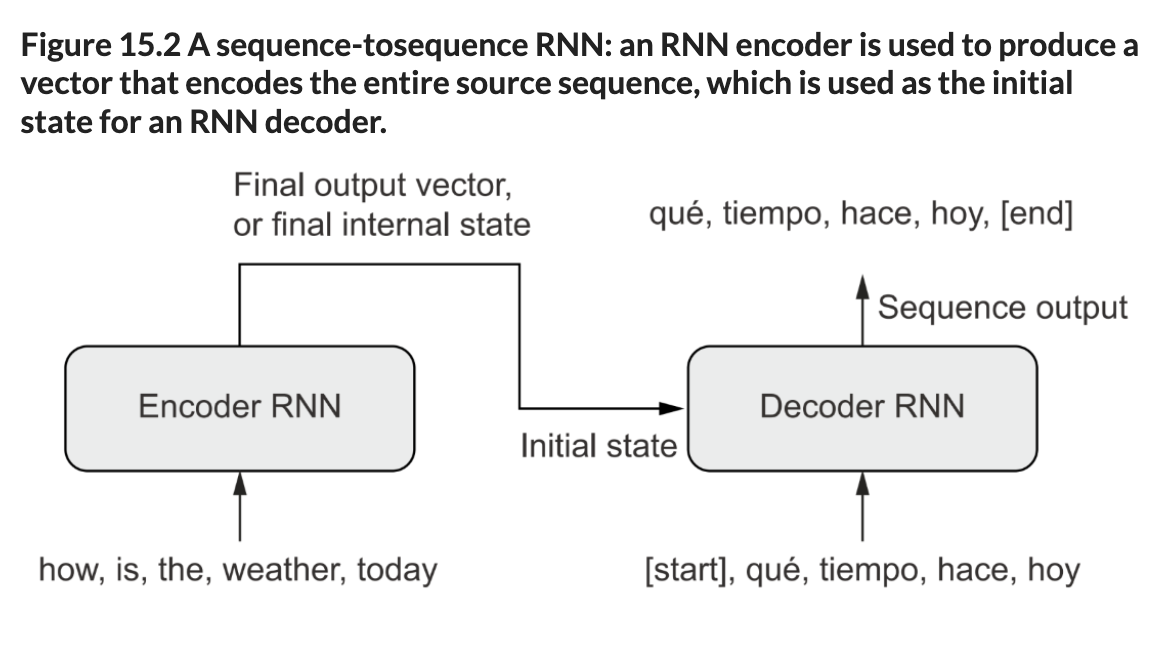

In [22]:

'''
embed_dim = 256
hidden_dim = 1024

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
rnn_layer = layers.GRU(hidden_dim)
rnn_layer = layers.Bidirectional(rnn_layer, merge_mode="sum")
encoder_output = rnn_layer(x)

'''

'\nembed_dim = 256\nhidden_dim = 1024\n\nsource = keras.Input(shape=(None,), dtype="int32", name="english")\nx = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)\nrnn_layer = layers.GRU(hidden_dim)\nrnn_layer = layers.Bidirectional(rnn_layer, merge_mode="sum")\nencoder_output = rnn_layer(x)\n\n'

Next, let’s add the decoder – a simple GRU layer that takes as its initial state the encoded source sentence. On top of it, we add a Dense layer that produces a probability distribution over the Spanish vocabulary for each output step. Here, we want to predict the next tokens based only on what came before.

In [23]:
'''
target = keras.Input(shape=(None,), dtype="int32", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(target)
rnn_layer = layers.GRU(hidden_dim, return_sequences=True)
x = rnn_layer(x, initial_state=encoder_output)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, target], target_predictions)
'''

'\ntarget = keras.Input(shape=(None,), dtype="int32", name="spanish")\nx = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(target)\nrnn_layer = layers.GRU(hidden_dim, return_sequences=True)\nx = rnn_layer(x, initial_state=encoder_output)\nx = layers.Dropout(0.5)(x)\ntarget_predictions = layers.Dense(vocab_size, activation="softmax")(x)\nseq2seq_rnn = keras.Model([source, target], target_predictions)\n'

In [24]:
#seq2seq_rnn.summary(line_length=80)

Start training.

In [25]:
'''
seq2seq_rnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)
'''

'\nseq2seq_rnn.compile(\n    optimizer="adam",\n    loss="sparse_categorical_crossentropy",\n    weighted_metrics=["accuracy"],\n)\nseq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)\n'

# Check For Inference

> **Definition: Check for Inference
>
> **check for inference** refers to verifying or ensuring that a model is being used in inference mode—that is, the phase where a trained model is applied to new, unseen data to make predictions, classifications, or decisions


At last, let’s use our model for inference. We’ll pick a few sentences in the test set and check how our model translates them. We’ll start from the seed token, "[start]", and feed it into the decoder model, together with the encoded English source sentence. We’ll retrieve a next-token prediction, and we’ll re-inject it into the decoder repeatedly, sampling one new target token at each iteration, until we get to "[end]" or reach the maximum sentence length.

# Listing 15.12 Generating translations with a seq2seq RNN


In [26]:
'''
import numpy as np

spa_vocab = spanish_tokenizer.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

def generate_translation(input_sentence):
    tokenized_input_sentence = english_tokenizer([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):
        tokenized_target_sentence = spanish_tokenizer([decoded_sentence])
        inputs = [tokenized_input_sentence, tokenized_target_sentence]
        next_token_predictions = seq2seq_rnn.predict(inputs, verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(generate_translation(input_sentence))
'''

'\nimport numpy as np\n\nspa_vocab = spanish_tokenizer.get_vocabulary()\nspa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))\n\ndef generate_translation(input_sentence):\n    tokenized_input_sentence = english_tokenizer([input_sentence])\n    decoded_sentence = "[start]"\n    for i in range(sequence_length):\n        tokenized_target_sentence = spanish_tokenizer([decoded_sentence])\n        inputs = [tokenized_input_sentence, tokenized_target_sentence]\n        next_token_predictions = seq2seq_rnn.predict(inputs, verbose=0)\n        sampled_token_index = np.argmax(next_token_predictions[0, i, :])\n        sampled_token = spa_index_lookup[sampled_token_index]\n        decoded_sentence += " " + sampled_token\n        if sampled_token == "[end]":\n            break\n    return decoded_sentence\n\ntest_eng_texts = [pair[0] for pair in test_pairs]\nfor _ in range(5):\n    input_sentence = random.choice(test_eng_texts)\n    print("-")\n    print(input_sentence)\n    print(generate

## How to Improve

We could use a deep stack of recurrent layers for both the encoder and the decoder, we could try other RNN layers like an LSTM. And so on. Beyond such tweaks, however, the RNN approach to sequence-to-sequence learning has a few fundamental limitations:

1. The source sequence representation has to be held entirely in the encoder state vector, which significantly limits the size and complexity of the sentences you can translate.

2. RNNs have trouble dealing with very long sequences since they tend to progressively forget about the past – by the time you’ve reached the 100th token in either sequence, little information remains about the start of the sequence.


# 15.3 The Transformer architecture

In 2017, Vaswani et al. introduced the Transformer architecture in the seminal paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762).  As it turned out, a simple mechanism called **attention** can be used to construct powerful sequence models that don’t feature recurrent layers at all.

Researchers noticed that while RNNs excel at modeling dependencies in a local neighborhood, they struggled with recall as sequences got longer.

RNNs, on the other hand, lack any mechanism to refer back to a previous section of a sequence directly. All information must, by design, be passed through an RNN cell’s internal state in a loop, through every position in a sequence. It’s a bit like finishing this book, closing it, and trying to implement that weather prediction model entirely from memory.

The idea with attention is to build a mechanism by which a neural network can give more weight to some part of a sequence and less weight to others contextually, depending on the current input being processed.






# 15.4 Dot-product attention

Let’s revisit our translation RNN and try to add the notion of selective attention. Consider predicting just a single token. After passing the source and target sequences through our GRU layers, we will have a vector representing the target token we are about to predict and a sequence of vectors representing each word in the source text.

With attention, our goal is to give the model a way to score every single vector in our source sequence based on its relevance to the current word we are trying to predict.


## Take Weighted Sum of Source Vectors and Run Softmax

For attention to work well, we want to avoid passing information about important tokens through a loop potentially as long as our combined source and target sequence length – this is where RNNs start to fail. A simple way to do this is to take a weighted sum of all the source vectors based on this score we will compute. It would also be convenient if the sum of all attention scores for a given target were one, as this would give our weighted sum a predictable magnitude. We can achieve this by running the scores through a softmax function.


```
scores = [score(target, source) for source in sources]
scores = softmax(scores)
combined = np.sum(scores * sources)
```
We can use a dot-product as a simple measure of the distance between target and source vectors. **If the source and target vectors are close together, we assume that means the source token is relevant to our prediction.**

```
def dot_product_attention(target, source):
    scores = np.einsum("btd,bsd->bts", target, source)  
    scores = softmax(scores, axis=-1)
    return np.einsum("bts,bsd->btd", scores, source)  

dot_product_attention(target, source)

```




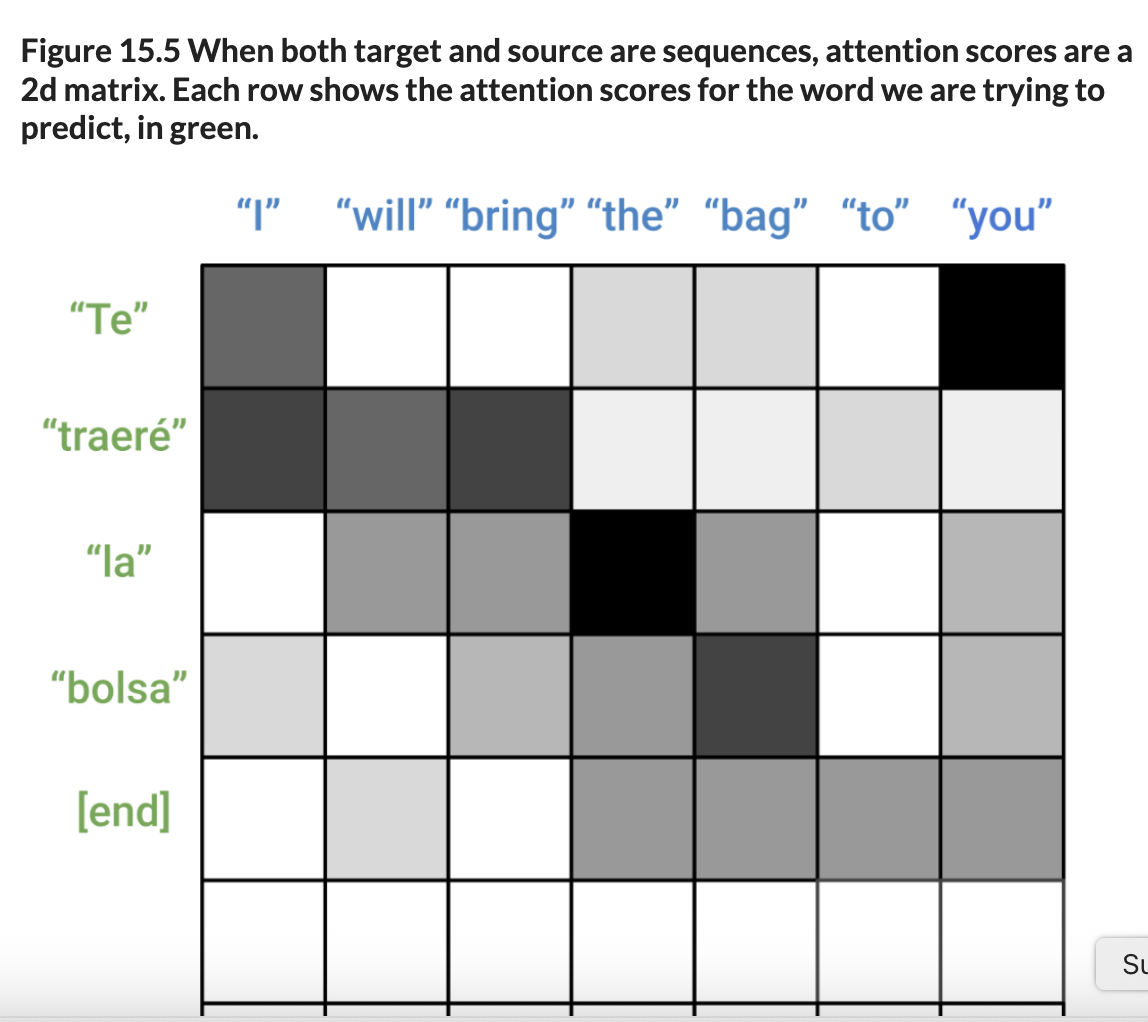

# 15.6 attention mechanism
This block is a perfectly functional attention mechanism! We just wrote a function that will allow the model to pull information from anywhere in the source sequence, contextually, depending on the target word we are decoding.

> **target,source, source rename to query, key, value**
>
> We can also adopt a slightly different naming for inputs that has become standard in the field. What we just wrote is roughly summarized as sum(score(target, source) * source). We will write this equivalently with different input names as sum(score(query, key) * value).

The terminology comes from search engines and recommender systems. Imagine a search tool to look up photos in a database – the “query” is your search term, the “keys” are photo tags you use to match with the query, and finally, the “values” are the photos themselves.


```
query_dense = layers.Dense(dim)
key_dense = layers.Dense(dim)
value_dense = layers.Dense(dim)
output_dense = layers.Dense(dim)

def parameterized_attention(query, key, value):
    query = query_dense(query)
    key = key_dense(key)
    value = value_dense(value)
    scores = np.einsum("btd,bsd->bts", query, key)
    scores = softmax(scores, axis=-1)
    outputs = np.einsum("bts,bsd->btd", scores, value)
    return output_dense(outputs)

parameterized_attention(query=target, key=source, value=source)
```

The Attention is all you need authors discovered two more changes to our mechanism through trial and error. The first is a simple scaling factor. When input vectors get long, the dot-product scores can get quite large, which can affect the stability of our softmax gradients. The fix is simple: we can scale down our softmax scores slightly. Scaling by the square root of the vector length works well for any vector size.

The other has to do with the expressivity of the attention mechanism. The softmax sum we are doing is powerful – it allows a direct connection across distant parts of a sequence. But the summation is also blunt, if the model tries to attend to too many tokens at once, the interesting features of individual source tokens will get “washed out” in the combined representation. A simple trick that works well is to do this attention operation several times for the same sequence, with several different attention heads running the same computation with different parameters:

```
query_dense = [layers.Dense(head_dim) for i in range(num_heads)]
key_dense = [layers.Dense(head_dim) for i in range(num_heads)]
value_dense = [layers.Dense(head_dim) for i in range(num_heads)]
output_dense = layers.Dense(head_dim * num_heads)

def multi_head_attention(query, key, value):
    head_outputs = []
    for i in range(num_heads):
        query = query_dense[i](query)
        key = key_dense[i](key)
        value = value_dense[i](value)
        scores = np.einsum("btd,bsd->bts", target, source)
        scores = softmax(scores / math.sqrt(head_dim), axis=-1)
        head_output = np.einsum("bts,bsd->btd", scores, source)
        head_outputs.append(head_output)
    outputs = ops.concatenate(head_outputs, axis=-1)
    return output_dense(outputs)

multi_head_attention(query=target, key=source, value=source)


```

### In Kerase this is:


```
multi_head_attention = keras.layers.MultiHeadAttention(
    num_heads=num_heads,
    head_dim=head_dim,
)
multi_head_attention(query=target, key=source, value=source)
```

## 15.5 Transformer Encoder block
[Chollet](https://livebook.manning.com/book/deep-learning-with-python-third-edition/chapter-15/v-4/159)

One way to use the MultiHeadAttention layer would be to add it to our existing RNN translation model. We could pass the sequence output from our encoder and decoder into an attention layer and use its output to update our target sequence before prediction. Attention would allow the model to handle long-range dependencies in text that the GRU layer will struggle with. This does, in fact, improve an RNN model’s capabilities and is how attention was first used in the mid-2010s.

However, the authors of Attention is all you need realized you could go further, and use attention as a general mechanism for handling all sequence data in a model. Although so far we have only looked at attention as a way to handle information passing between two sequences, you could also use attention as a way to let a sequence attend to itself:

```
multi_head_attention(key=source, value=source, query=source)

```

This is called **self-attention** and is quite powerful. With self-attention, each token can attend to every token in its own sequence, including itself, allowing the model to learn a representation of the word in context.

Consider an example sentence: “The train left the station on time.” Now, consider one word in the sentence: “station.” What kind of station are we talking about? Could it be a radio station? Maybe the International Space Station? With self-attention, the model could learn to give a high attention score to the pair of “station” and “train,” summing the vector used to represent “train” into the representation of the word “station.”





## Listing 15.13 A Transformer Encoder block.



In [27]:
class TransformerEncoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, source, source_mask):
        residual = x = source
        mask = source_mask[:, None, :]
        x = self.self_attention(query=x, key=x, value=x, attention_mask=mask)
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

We also pass a new input to the MultiHeadAttention layer called **attention_mask**. This boolean tensor input will be broadcast to the same shape as our attention scores, (batch_size, target_length, source_length).

When set, it will zero the attention score in specific locations, stopping the source tokens at these locations from being used in the attention calculation.


## 15.6 Transformer Decoder block
Next up is the decoder block. This layer will be almost identical to the encoder block, except we want the decoder to use the encoder output sequence as an input. To do this, we can use attention twice. We first apply a self-attention layer like our encoder, which allows each position in the target sequence to use information from other target positions. We then add another MultiHeadAttention layer, which receives both the source and target sequence as input. We will call this attention layer cross-attention as it brings information across the encoder and decoder.

In [28]:
class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        self.cross_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.cross_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, target, source, source_mask):
        residual = x = target
        x = self.self_attention(query=x, key=x, value=x, use_causal_mask=True)
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        mask = source_mask[:, None, :]
        x = self.cross_attention(
            query=x, key=source, value=source, attention_mask=mask
        )
        x = x + residual
        x = self.cross_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

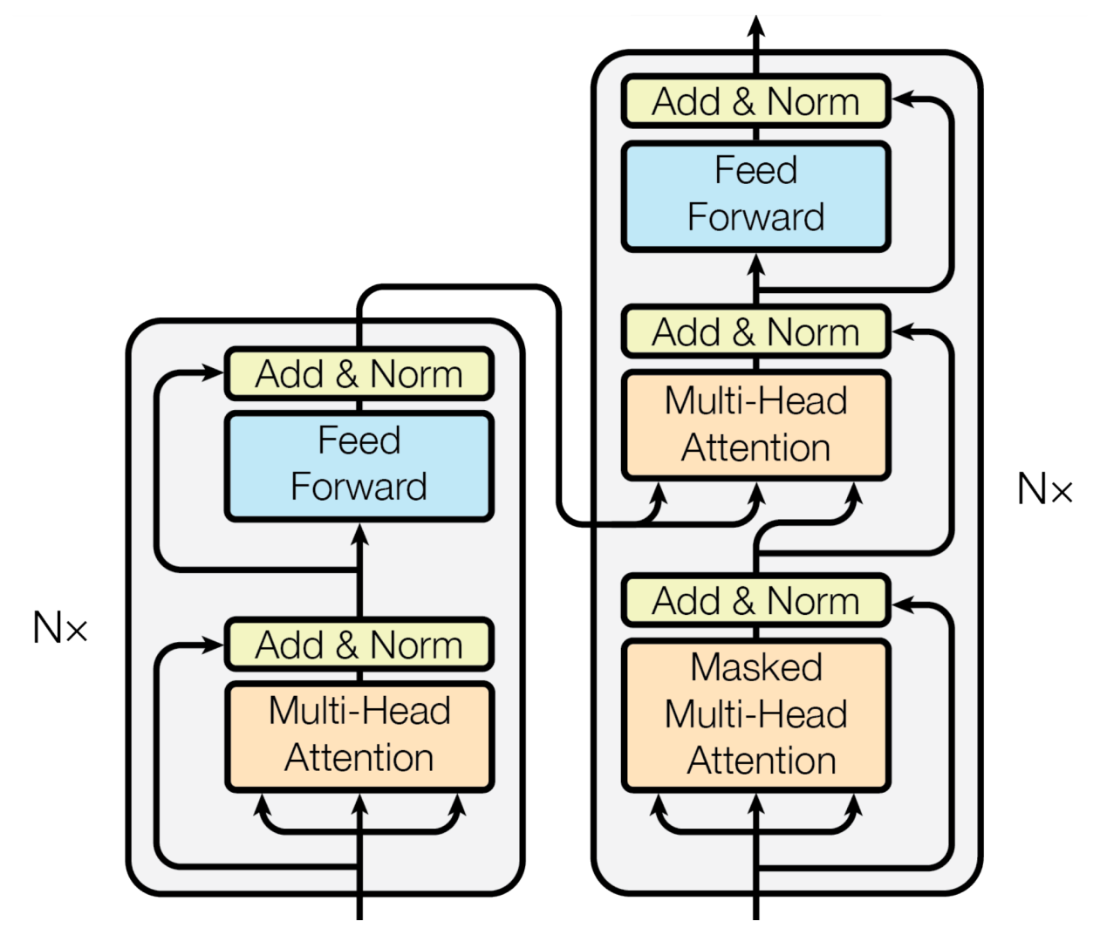

#15.7 Sequence-to-sequence learning with a Transformer
Let’s try putting this all together. We will use the same basic setup as our RNN model, replacing the GRU layers with our TransformerEncoder and TransformerDecoder. We will use our 256 as the entire model’s hidden feature size except for the feedforward block’s inner dimension. In the feedforward block, we scale up the feature size to 2048 before non-linearity and scale back to the model’s hidden size afterward. This large intermediate dimension works well in practice.

In [29]:
import keras
from keras import layers

hidden_dim = 256
intermediate_dim = 2048
num_heads = 8
vocab_size = 15000

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = layers.Embedding(vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(hidden_dim, intermediate_dim, num_heads)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="spanish")
x = layers.Embedding(vocab_size, hidden_dim)(target)
x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([source, target], target_predictions)

In [30]:
transformer.summary(line_length=80)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ english (InputLayer)  │ (None, None)      │           0 │ -                  │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embedding_3           │ (None, None, 256) │   3,840,000 │ english[0][0]      │
│ (Embedding)           │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ not_equal_2           │ (None, None)      │           0 │ english[0][0]      │
│ (NotEqual)            │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ spanish (InputLayer)  │ (None, None)      │           0 │ -                  │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_encoder_1 │ (None, None, 256) │   1,315,072 │ embedding_3[0][0], │
│ (TransformerEncoder)  │                   │             │ not_equal_2[0][0]  │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ not_equal_3           │ (None, None)      │           0 │ english[0][0]      │
│ (NotEqual)            │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embedding_4           │ (None, None, 256) │   3,840,000 │ spanish[0][0]      │
│ (Embedding)           │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_decoder_1 │ (None, None, 256) │   1,578,752 │ transformer_encod… │
│ (TransformerDecoder)  │                   │             │ not_equal_3[0][0], │
│                       │                   │             │ embedding_4[0][0]  │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ dropout_7 (Dropout)   │ (None, None, 256) │           0 │ transformer_decod… │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ dense_9 (Dense)       │ (None, None,      │   3,855,000 │ dropout_7[0][0]    │
│                       │ 15000)            │             │                    │
└───────────────────────┴───────────────────┴─────────────┴────────────────────┘

 Total params: 14,428,824 (55.04 MB)

 Trainable params: 14,428,824 (55.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 73s 44ms/step - accuracy: 0.2821 - loss: 1.7764 - val_accuracy: 0.5088 - val_loss: 1.0130
Epoch 2/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 47s 36ms/step - accuracy: 0.5165 - loss: 1.0258 - val_accuracy: 0.5763 - val_loss: 0.8169
Epoch 3/15
  23/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.5735 - loss: 0.8491

Listing 15.17 Building a Transformer model with position embeddings.

In [ ]:
Lhidden_dim = 256
intermediate_dim = 2056
num_heads = 8

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(hidden_dim, intermediate_dim, num_heads)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)(target)
x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([source, target], target_predictions)

In [ ]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

In [ ]:
import numpy as np

spa_vocab = spanish_tokenizer.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

def generate_translation(input_sentence):
    tokenized_input_sentence = english_tokenizer([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):
        tokenized_target_sentence = spanish_tokenizer([decoded_sentence])
        tokenized_target_sentence = tokenized_target_sentence[:, :-1]
        inputs = [tokenized_input_sentence, tokenized_target_sentence]
        next_token_predictions = transformer.predict(inputs, verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(generate_translation(input_sentence))